Data downloaded manually from the Yahoo Finance website.

In [29]:
import pandas as pd
import os
import seaborn as sns
from datetime import date

In [30]:
def read_etf_csv(filepath):
    df = pd.read_csv(filepath)[["Date", "Close"]]
    df["Date"] = pd.to_datetime(df["Date"])
    df.rename(columns = {"Close": os.path.basename(filepath).split(".")[0]}, inplace = True)
    return df

In [31]:
START_DATE = date(2000, 1, 1)
END_DATE = date(2022, 12, 31)

time_diff = (END_DATE - START_DATE).days

etf_df = pd.DataFrame({'Date': pd.date_range(START_DATE, periods = time_diff + 1, freq = 'D')})

In [32]:
with os.scandir('data/') as entries:
    for entry in entries:
        etf_df = etf_df.merge(read_etf_csv(entry), on = "Date", how = "left")

<bound method NDFrame.head of            Date  AGG       IGLN       IWDA
0    2000-01-01  NaN        NaN        NaN
1    2000-01-02  NaN        NaN        NaN
2    2000-01-03  NaN        NaN        NaN
3    2000-01-04  NaN        NaN        NaN
4    2000-01-05  NaN        NaN        NaN
...         ...  ...        ...        ...
8396 2022-12-27  NaN  35.021252  73.169998
8397 2022-12-28  NaN        NaN        NaN
8398 2022-12-29  NaN        NaN        NaN
8399 2022-12-30  NaN        NaN        NaN
8400 2022-12-31  NaN        NaN        NaN

[8401 rows x 4 columns]>

<AxesSubplot: >

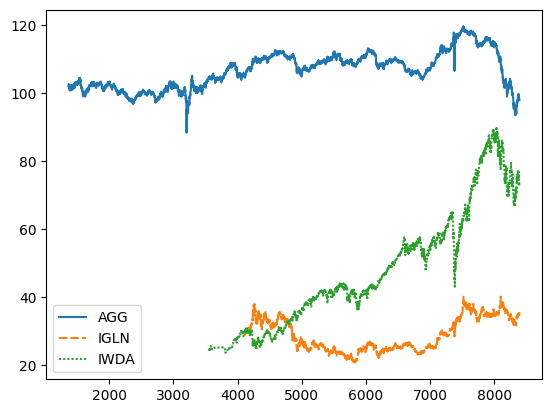

In [33]:
sns.lineplot(data = etf_df)

To-dos:

- basic portfolio visualisation and optimisation
- what is the difference between "close" and "adj close"?
- make sure these are the funds you would actually consider buying
- expand the analysed portfolio with additional ETFs

To-dos (later):
- translate all currencies to PLN
- introduce the notion of transaction costs when buying new ETFs (price of a single ETF, transaction fees)